# Analyzing a Phase I Clinical Trial

Welcome to the AI Hub's tutorial on analyzing Phase I Trials! In this Jupyter notebook you will find a guide to analyzing a simple Phase I trial using fictional data.

Typically, Phase I trials aim to find the appropriate dosage of a new treatment by administering it to a small group of healthy participants. Then, researchers monitor the participants' reaction, collect data, and use the data to determine human tolerance to the new treatment. [Further reading can be done at fda.gov](https://www.fda.gov/patients/learn-about-drug-and-device-approvals/drug-development-process).

In our case study here, the new treament is given to test subjects either 1, 2, or 3 times. These dosages are indicated by a "dose number", and if the subject has an adverse reaction, the severity and duration of the reaction is recorded. We will be looking to answer three questions:

1. What is the frequency and severity of adverse events from Phase I?
2. Are there any dose-related trends in the adverse events?
3. What recommendations can we make regarding Phase II?

By the end of this tutorial, we will see that adverse effects occur 37% of the time, but the majority of these events are mild in severity. At this point, we are not able to conclude that the duration of the mild adverse events is affected by the dose number, but further testing could clarify the picture. 

Let's dive in!


## Imports

First, we will import a handful of modules. You may need to install one of these packages using the command line tool `pip`. [Instructions can be found here.](https://pypi.org/project/pip/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import f_oneway

pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Read Data

Next, we will read in the data and take a look at each table by using the `head` method. Our data is stored in two csv's: `synthetic_participant_data.csv` and `synthetic_dose_data.csv'`. Both can be found in the `data/` directory included in this repo.

In [2]:
participants_df = pd.read_csv('./data/synthetic_participant_data.csv', 
                              keep_default_na=False)

dose_df = pd.read_csv('./data/synthetic_dose_data.csv', keep_default_na=False)

In [3]:
participants_df.head()

,ParticipantID,Age,Gender,Ethnicity,Weight,Height,MedicalHistory,BaselineVitals,InclusionCriteriaMet,ExclusionCriteriaMet,Accepted,Started,Finished
0,0,62,Male,Ethnicity1,61,164,History2,Elevated,False,0,0,0,0
1,1,49,Male,Ethnicity1,76,166,History2,Slightly Elevated,True,0,0,0,0
2,2,62,Male,Ethnicity2,57,172,History2,Normal,True,0,0,0,0
3,3,64,Other,Ethnicity4,74,173,History1,Elevated,False,0,0,0,0
4,4,38,Other,Ethnicity4,95,194,None,Normal,False,0,0,0,0


In [4]:
dose_df.head()

,DoseID,ParticipantID,DoseNumber,AdministrationDate,AdverseEvents,SeverityOfAdverseEvents,DurationOfAdverseEvents,VitalsPostDose,LabResultsPostDose
0,1,368,1,2023-01-15,None,None,0,Normal,Abnormal
1,2,368,2,2023-01-09,Mild,High,3,Elevated,Within Normal Limits
2,3,481,1,2023-01-08,Mild,Low,3,Normal,Slightly Abnormal
3,4,481,2,2023-01-07,None,None,0,Elevated,Within Normal Limits
4,5,481,3,2023-01-08,None,None,0,Normal,Abnormal


We can see that our `participants_df` table contains a row for each participant and includes biometric data as well as fields regarding participation in our Phase I trial. The `Accepted`, `Started`, and `Finished` fields show that not every participant was actually given a dose of the treatment.

Our `dose_df` table contains a row for each dose administered alongside information on the paricipants' reaction to the treatment. This table shares a common `ParticipantID` with `participants_df` and thus can be joined on this column.

## Descriptive Data

No data analysis is complete without some descriptive data! A deep dive here is outside the scope of this tutorial since we are focusing on the relationship between dose amount and adverse effects, but it is good practice to always have some understanding of the data we have at our disposal.

### Participants

Let's take a look at the number of participants who `Accepted`, `Started`, and `Finished` the trial, and then summarize our categorical and numeric fields.

In [5]:
trial_participation_columns = ['Accepted', 'Started', 'Finished']

participants_df[trial_participation_columns].agg(['count', 'sum'])

,Accepted,Started,Finished
count,541,541,541
sum,69,67,59


While the trial reached out to 541 potential participants, only 69 accepted. Of those 69, 67 took a single dose and 59 completed the entire study. Now, let's look at the categorical variables.

In [6]:
categorical_cols = ['Gender', 'Ethnicity', 'MedicalHistory', 'BaselineVitals']

participants_df[categorical_cols].describe()

,Gender,Ethnicity,MedicalHistory,BaselineVitals
count,541,541,541,541
unique,3,4,3,3
top,Male,Ethnicity2,History1,Normal
freq,189,143,194,190


The `unique` row shows the number of possible values in each field. The `top` row states the mode of the field, and the `freq` row indicates the amount of times the mode appears. Moving onto our numeric data:

In [7]:
numeric_cols = ['Age', 'Weight', 'Height']

participants_df[numeric_cols].describe()

,Age,Weight,Height
count,541.00,541.00,541.00
mean,40.84,73.57,174.57
std,13.78,14.41,14.26
min,18.00,50.00,150.00
25%,28.00,61.00,163.00
50%,42.00,73.00,174.00
75%,53.00,85.00,187.00
max,64.00,99.00,199.00


The above table summarizes the participants' `Age`, `Weight`, and `Height`. These values are for all participants that the trial reached out to, not just the ones who eventually enrolled in the study.

Thus, it is important to confirm that there is no selection bias in our trial. In this tutorial, we will simply compare the demographics of participants who completed the trial vs. all the participants, but we encourage those using real world data to take a deeper look at this stage. One way to achieve this is to use t-tests to confirm that the group that accepted the trial is not siginificantly different from the group that did not. One could also compare these values to the general population as a secondary check.

In [8]:
categories_to_check = ['Gender', 'Ethnicity', 
                       'MedicalHistory', 'BaselineVitals']

for categorical_col in categories_to_check:
    display(pd.crosstab(participants_df['Finished'], 
                        participants_df[categorical_col], 
                        normalize='index', 
                        margins=True).style.format("{:.2%}"))

Gender,Female,Male,Other
Finished,,,
0,31.33%,34.65%,34.02%
1,40.68%,37.29%,22.03%
All,32.35%,34.94%,32.72%


Ethnicity,Ethnicity1,Ethnicity2,Ethnicity3,Ethnicity4
Finished,,,,
0,22.82%,27.39%,23.86%,25.93%
1,33.90%,18.64%,20.34%,27.12%
All,24.03%,26.43%,23.48%,26.06%


MedicalHistory,History1,History2,None
Finished,,,
0,35.89%,28.42%,35.68%
1,35.59%,42.37%,22.03%
All,35.86%,29.94%,34.20%


BaselineVitals,Elevated,Normal,Slightly Elevated
Finished,,,
0,31.74%,36.10%,32.16%
1,35.59%,27.12%,37.29%
All,32.16%,35.12%,32.72%


In [9]:
pd.pivot_table(participants_df, values=numeric_cols, index='Finished')

,Age,Height,Weight
Finished,,,
0,40.69,174.80,73.53
1,42.03,172.69,73.90


### Dose

Now, let's take a look at `dose_df`! First, let's start with the categorical variables. We should note that our `DoseNumber` column is stored as an `int`, but we want to treat dose numbers 1, 2, and 3 as distinct categories. In order to do so, we cast the column as a `str`.

In addition, our trial design requires that those who receieved dose #3 are guaranteed to have recieved dose #2, and those who received dose #2 are guaranteed to have recieved dose #1. With real world data, these assumptions should be checked. For example, you should check the date field to ensure that the dose numbers correspond to the order the doses were given in.

In [10]:
categorical_cols = ['DoseNumber', 'AdverseEvents', 'SeverityOfAdverseEvents', 
                    'VitalsPostDose', 'LabResultsPostDose']

dose_categorial_df = dose_df[categorical_cols].copy()

dose_categorial_df['DoseNumber'] = dose_categorial_df['DoseNumber'].astype(str)

dose_categorial_df.describe()

,DoseNumber,AdverseEvents,SeverityOfAdverseEvents,VitalsPostDose,LabResultsPostDose
count,126,126,126,126,126
unique,3,4,4,3,3
top,1,None,None,Normal,Abnormal
freq,67,79,79,56,49


It's good to see that our most common `AdverseEvents` is `None`! Now we can take a look at the numeric field in the `dose_df` table, `DurationOfAdverseEvents`.

In [11]:
dose_numeric_cols = ['DurationOfAdverseEvents']

dose_df[dose_numeric_cols].describe()

,DurationOfAdverseEvents
count,126.00
mean,1.02
std,1.53
min,0.00
25%,0.00
50%,0.00
75%,2.00
max,4.00


The mean duration of an adverse event is `1.02` days. Not bad!

We are finally ready to answer our first question: _What is the frequency and severity of adverse events from Phase I?_

Let's start with the frequency:

In [12]:
dose_df['HadAdverseEvent'] = (dose_df['AdverseEvents']!='None')

had_adevent_freq = dose_df['HadAdverseEvent'].value_counts(normalize=True)

pd.DataFrame(had_adevent_freq)

,proportion
HadAdverseEvent,
False,0.63
True,0.37


37% of doses resulted in an adverse event, while 63% did not. If these adverse events were frequently mild in nature, then our treatment might be sufficently safe. Now, let's see severity as a percent of those with adverse events:

In [13]:
dose_adevents_df = dose_df[dose_df['AdverseEvents']!='None']

adevent_freq = dose_adevents_df['AdverseEvents'].value_counts(normalize=True)

pd.DataFrame(adevent_freq)

,proportion
AdverseEvents,
Mild,0.51
Moderate,0.26
Severe,0.23


51% of the adverse events were `Mild`&#151;just barely the majority. Now, let's look at adverse events in light of an additional variable, `DoseNumber`. 

## Exploring the relationship between dose trends and adverse events

Time for question 2: _Are there any dose-related trends in the adverse events?_

We can visualize the answer to this question by looking at the frequency and severity of adverse events by dose, both as a raw count and as a percentage. We will also check the adverse event duration for completeness.

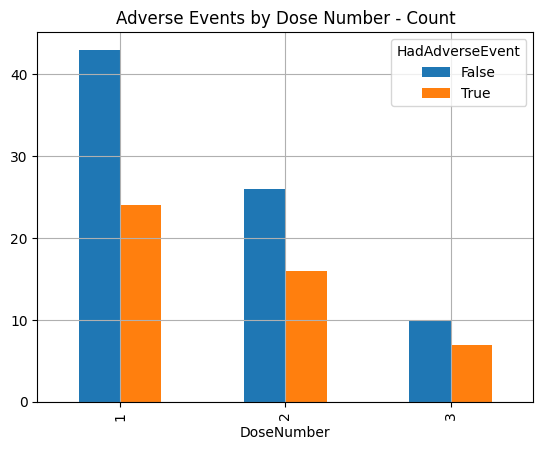

In [14]:
dose_num_by_ad_events = pd.crosstab(dose_df['DoseNumber'], 
                                    dose_df['HadAdverseEvent'])

ax = dose_num_by_ad_events.plot(kind="bar", grid=True)
ax.set_title("Adverse Events by Dose Number - Count")

plt.show()

We already know that less partipants took dose #3 than dose #2 and that less took dose #2 than dose #1, so we need to normalize these figures:

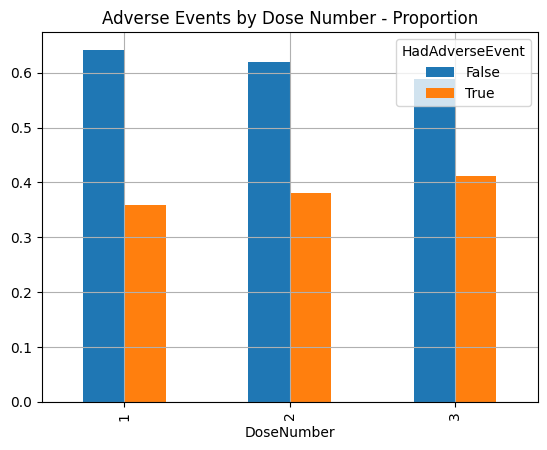

In [15]:
dose_num_by_ad_events_normed = pd.crosstab(dose_df['DoseNumber'], 
                                           dose_df['HadAdverseEvent'], 
                                           normalize='index')

ax = dose_num_by_ad_events_normed.plot(kind="bar", grid=True)
ax.set_title("Adverse Events by Dose Number - Proportion")

plt.show()

According to our data, the number of participants who experenced an adverse event slightly increased with additional doses. However, we cannot draw any conclusions from this chart alone due to the different sample sizes.

We can also create charts that look at the severity of `AdverseEvents` by `DoseNumber`:

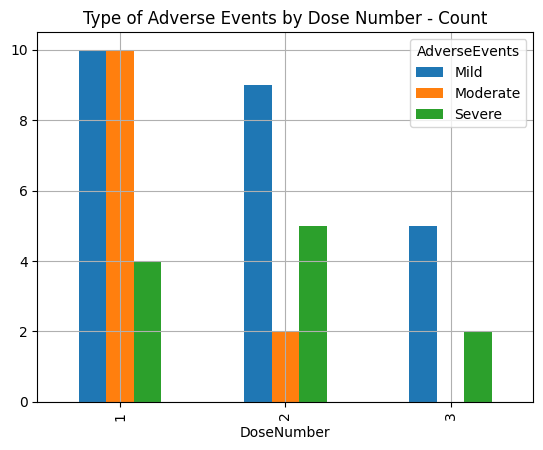

In [16]:
dose_by_adevents = pd.crosstab(dose_df['DoseNumber'], 
                               dose_df['AdverseEvents'])

ax = dose_by_adevents[['Mild', 'Moderate', 'Severe']].plot(kind="bar", grid=True)

ax.set_title("Type of Adverse Events by Dose Number - Count")
plt.show()

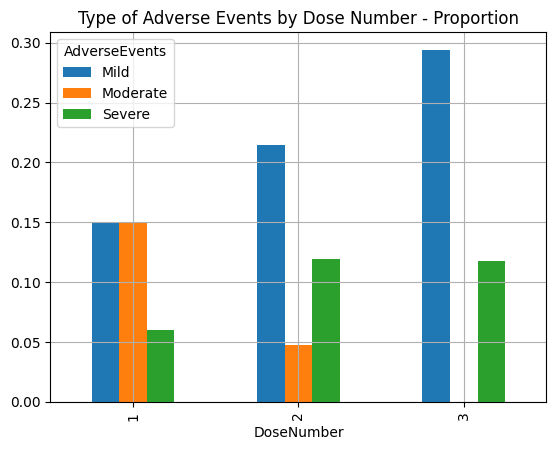

In [17]:
dose_by_adevents_normed = pd.crosstab(dose_df['DoseNumber'], 
                                      dose_df['AdverseEvents'], 
                                      normalize='index')

ax = dose_by_adevents_normed[['Mild', 'Moderate', 'Severe']].plot(kind="bar", grid=True)
ax.set_title("Type of Adverse Events by Dose Number - Proportion")
plt.show()

`Mild` events make up a higher percentage adverse events in subsequent doses, while `Moderate` events make up a lesser percentage.

Let's shift over to `DurationOfAdverseEvents`:

In [18]:
pd.pivot_table(dose_df[dose_df['HadAdverseEvent']], 
               values='DurationOfAdverseEvents', 
               index='AdverseEvents')

,DurationOfAdverseEvents
AdverseEvents,
Mild,2.71
Moderate,2.67
Severe,2.91


Overall, `Mild`, `Moderate`, and `Severe` events have fairly similar durations with `Moderate` events occuring for the shortest duration on average and `Severe` events occuring the longest. We can look at these means by `DoseNumber` as well:

In [19]:
pd.pivot_table(dose_df[dose_df['HadAdverseEvent']], 
               values='DurationOfAdverseEvents', 
               index='DoseNumber', columns='AdverseEvents')

AdverseEvents,Mild,Moderate,Severe
DoseNumber,,,
1,3.00,2.90,3.00
2,2.67,1.50,2.80
3,2.20,NaN,3.00


On average, `Mild` events occured for shorter periods of time after subsequent doses. In contrast, `Severe` events show no clear trend.

One hypothesis we might have after considering these charts is that `Mild` adverse events become more likely than `Moderate` or `Severe` ones after repeated doses. 

Another hypothesis we can formulate is that the duration of `Mild` adverse effects lessens after repeated doses.

For the purposes of this tutorial, we will test the second hypothesis by using one-way ANOVA, which tests whether the means of different groups are significantly different. In this experimental setup, our hypothesis can be written as:

- H<sub>0</sub>: The groups that took 1, 2, and 3 doses of treatment have an equal mean duration of `Mild` adverse reactions
- H<sub>$\alpha$</sub>: At least one of the above groups is different from the others in regards to `Mild` adverse reaction duration

Using a 95% condfidence threshold, if our ANOVA test p-value is < 0.05, we can reject H<sub>0</sub>. 

In [20]:
anova_data = dose_df[dose_df['AdverseEvents']=='Mild']

def get_anova_group(i):
    return(anova_data[anova_data['DoseNumber']==i]['DurationOfAdverseEvents'])

anova_groups = [get_anova_group(i) for i in [1, 2, 3]]

f_oneway(*anova_groups)

F_onewayResult(statistic=0.7868923611111112, pvalue=0.46822717419525445)

Our p-value is is 0.4682 and thus we cannot reject our H<sub>0</sub> at this point. This means that we cannot definitively state that our three `DoseNumber` groups are significantly different in regards to the mean of `DurationOfAdverseEvents` given the data we have collected in our Phase I trial.

## Recommendations on a Phase II Trial

Let's look at question 3: _What recommendations do you have for proceeding to Phase II?_

Phase II trials also look at adverse reactions but do so by administering the treatment to the population it is aimed at. At this point, we have run one statistical test and were not able to reject the H<sub>0</sub>. However, the Phase II trial will collect a larger number of observations, so the test can be repeated with a larger sample size. 

In addition, we could consider other tests to run and data to collect. One suggestion we might make is to collect the severity metric as a score from 1-10. Then, we could use the severity metric in statistical tests focused on mean testing like t-tests and ANOVA.

On the safety side, we observed only 11 `Severe` reactions, but these reactions did not seem to be influenced by the number of doses taken. Still, as more participants are added, this number should be monitored closely and be subjected to a statistical test.

## Conclusion

Congratulations on completing this tutorial! We love to hear your feedback and welcome you to email [feedback@dominodatalab.com](https://media3.giphy.com/media/111ebonMs90YLu/200.gif) with comments or concerns you may have.